In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.phenotype import convert_to_phen

from test_phenotype_sim.phenotype_test import test_variance


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
if [ ! -f test-200-samples.grg ]; then
  grg construct -p 10 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg
fi

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = 0.0  
var_1 = 1.0  
model_normal = grg_causal_mutation_model("normal", mean=mean_1, var=var_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [-7.43701930e-01 -8.71322147e-01  2.00176475e-01 -3.29854085e-01
  1.88219157e+00  1.34084410e+00 -7.62417524e-01  8.03662573e-01
 -1.47445212e+00  1.32076511e+00  5.54204000e-01  3.01731270e+00
  1.91862739e-01 -5.74322304e-01 -1.39384215e-02  9.17137182e-02
  2.31974546e-01 -2.08528398e-01 -2.74263798e-01 -3.18802935e-01
 -4.70575539e-01  5.44184515e-01 -2.34190388e+00  2.11582039e+00
  1.52832579e+00  4.53319627e-01 -1.50436153e+00  3.50525514e-01
  2.74469932e-01  1.26630721e-01 -2.62713548e+00  9.00480454e-01
  9.60206504e-01 -5.15038548e-01  4.53719132e-01  1.10898012e+00
 -8.48163160e-01  8.30716629e-01 -4.12795644e-01  3.65994383e-01
  8.74408817e-01  2.01419367e+00  1.56083652e+00 -1.02153717e+00
 -1.09028303e+00 -4.99114316e-01  1.51799685e+00  1.11678055e+00
  2.54959501e+00 -7.07758523e-01  6.44074752e-01  1.62977256e-02
 -1.13385382e+00  1.84672429e+00  1.97955414e+00 -4.25821031e-01
 -1.98803400e-01 -3.43350435e-02  1.23929027e+00  1.26394644e+00
 

In [5]:

trait_df_normal = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal, random_seed=1)
sample_nodes_df = additive_effect_sizes(grg_1, trait_df_normal)

In [6]:
individual_genetic_value_df = samples_to_individuals(sample_nodes_df) #non-normalized genetic value df
individual_genetic_value_df

,individual_id,genetic_value,causal_mutation_id
0,0,-16.501664,0
1,1,-2.454348,0
2,2,-17.303803,0
3,3,6.641214,0
4,4,-8.710213,0
...,...,...,...
195,195,12.536488,0
196,196,16.549154,0
197,197,5.463626,0
198,198,-0.663779,0


We first show how to simulate environmental noise before the genetic values have been normalized, with a narrow-sense heritability of 0.5.

In [7]:
phenotypes = sim_env_noise(individual_genetic_value_df, h2=0.5) #simulating environmental noise without normalizing genetic values
phenotype_df = phenotypes.phenotype_df
phenotype_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,-22.138435,-38.640098
1,0,1,-2.454348,-14.218369,-16.672717
2,0,2,-17.303803,-15.709099,-33.012903
3,0,3,6.641214,-0.818618,5.822596
4,0,4,-8.710213,-7.337457,-16.047670
...,...,...,...,...,...
195,0,195,12.536488,12.081788,24.618277
196,0,196,16.549154,-9.297114,7.252040
197,0,197,5.463626,-7.099086,-1.635460
198,0,198,-0.663779,9.266719,8.602940


In [8]:
h2_used = phenotypes.get_h2() #showing the h2 factor used, can be acccessed since it is a class attribute of phenotypes
print(h2_used)

[0.5]


In [9]:
phenotype_df = normalize(phenotypes)
test1 = test_variance(phenotype_df)
print("Variance of the phenotypes is " + str(phenotype_df['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df['environmental_noise'].var()))
print(test1)   #tests the variance condition in the phenotypic data, expected value close to zero
phenotype_df

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.4528386050964378
Variance of the noise is 0.42648567037992025
0.12067572452364195


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.252732,-1.103308,-1.356040
1,0,1,0.461892,-0.700393,-0.238502
2,0,2,-0.293539,-0.776231,-1.069770
3,0,3,0.924607,-0.018713,0.905894
4,0,4,0.143639,-0.350343,-0.206704
...,...,...,...,...,...
195,0,195,1.224515,0.637564,1.862079
196,0,196,1.428649,-0.450036,0.978613
197,0,197,0.864700,-0.338217,0.526483
198,0,198,0.552982,0.494354,1.047337


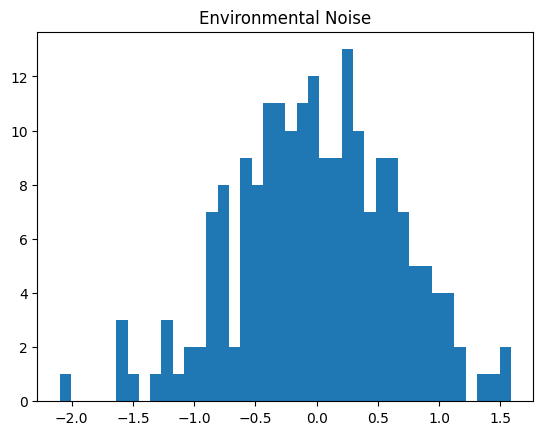

Mean of noise: -1.7763568394002505e-17
Standard deviation of noise: 0.653058703624659


In [10]:

plt.hist(phenotype_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df['environmental_noise'].std()))

Now, we show a sample where zero noise is simulated (h2=1) by default.

In [11]:
phenotypes_zero_noise = sim_env_noise(individual_genetic_value_df) #simulating environmental noise without normalizing genetic values
phenotype_df_zero_noise = phenotypes_zero_noise.phenotype_df
phenotype_df_zero_noise

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-16.501664
1,0,1,-2.454348,0.0,-2.454348
2,0,2,-17.303803,0.0,-17.303803
3,0,3,6.641214,0.0,6.641214
4,0,4,-8.710213,0.0,-8.710213
...,...,...,...,...,...
195,0,195,12.536488,0.0,12.536488
196,0,196,16.549154,0.0,16.549154
197,0,197,5.463626,0.0,5.463626
198,0,198,-0.663779,0.0,-0.663779


In [12]:
phenotype_df_zero_noise = normalize(phenotypes_zero_noise)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise['environmental_noise'].var()))
phenotype_df_zero_noise

Variance of the phenotypes is 0.9999999999999997
Variance of the genetic values is 174.97473363027564
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.0,-0.375568
1,0,1,-2.454348,0.0,0.686386
2,0,2,-17.303803,0.0,-0.436209
3,0,3,6.641214,0.0,1.373995
4,0,4,-8.710213,0.0,0.213453
...,...,...,...,...,...
195,0,195,12.536488,0.0,1.819668
196,0,196,16.549154,0.0,2.123019
197,0,197,5.463626,0.0,1.284972
198,0,198,-0.663779,0.0,0.821750


In [13]:
phenotype_df_zero_noise_genetic_normalize = normalize(phenotypes_zero_noise, normalize_genetic_values=True)
print("Variance of the phenotypes is " + str(phenotype_df_zero_noise_genetic_normalize['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_zero_noise_genetic_normalize['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_zero_noise_genetic_normalize['environmental_noise'].var()))
phenotype_df_zero_noise_genetic_normalize


Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.9999999999999997
Variance of the noise is 0.0


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.0,-0.375568
1,0,1,0.686386,0.0,0.686386
2,0,2,-0.436209,0.0,-0.436209
3,0,3,1.373995,0.0,1.373995
4,0,4,0.213453,0.0,0.213453
...,...,...,...,...,...
195,0,195,1.819668,0.0,1.819668
196,0,196,2.123019,0.0,2.123019
197,0,197,1.284972,0.0,1.284972
198,0,198,0.821750,0.0,0.821750


Now, we simulate environmental noise before the genetic values have been normalized, with user defined noise. If user_defined is set to True, the user must specify mean and std values to be simulated from.

In [14]:
phenotype_non_normalized_user_defined = sim_env_noise(individual_genetic_value_df, user_defined=True, mean=0, std=1) #simulating standard noise on the non-normalized genetic values
phenotype_df_non_normalized_user_defined = phenotype_non_normalized_user_defined.phenotype_df
phenotype_df_non_normalized_user_defined

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-16.501664,0.164575,-16.337088
1,0,1,-2.454348,2.357646,-0.096702
2,0,2,-17.303803,-0.554507,-17.858310
3,0,3,6.641214,-0.707333,5.933881
4,0,4,-8.710213,-0.355756,-9.065969
...,...,...,...,...,...
195,0,195,12.536488,-0.581644,11.954844
196,0,196,16.549154,0.059071,16.608225
197,0,197,5.463626,1.316490,6.780115
198,0,198,-0.663779,-0.607590,-1.271369


The user can choose to view the h2 narrow sense heritability factor for the user-defined noise as well.

In [15]:
h2_user_defined = phenotype_non_normalized_user_defined.get_h2()
print(h2_user_defined)

0.9998839973622435


In [16]:
phenotype_df_non_normalized_user_defined = normalize(phenotype_non_normalized_user_defined)
print("Variance of the phenotypes is " + str(phenotype_df_non_normalized_user_defined['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_non_normalized_user_defined['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].var()))
phenotype_df_non_normalized_user_defined

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.9944661659371514
Variance of the noise is 0.005417831425092111


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.374528,0.012213,-0.362314
1,0,1,0.684484,0.177546,0.862030
2,0,2,-0.435000,-0.041998,-0.476998
3,0,3,1.370188,-0.053519,1.316669
4,0,4,0.212861,-0.027014,0.185847
...,...,...,...,...,...
195,0,195,1.814626,-0.044043,1.770583
196,0,196,2.117137,0.004259,2.121396
197,0,197,1.281411,0.099055,1.380466
198,0,198,0.819473,-0.045999,0.773474


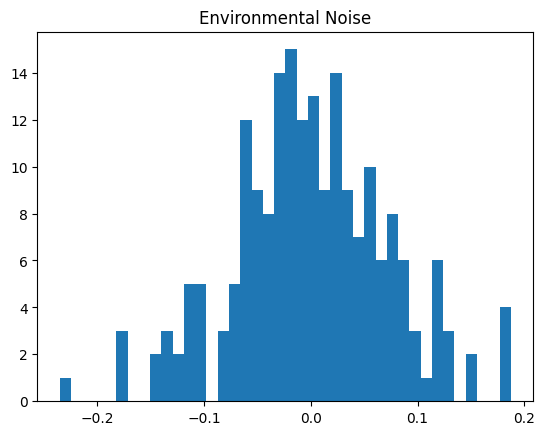

Mean of noise: 2.0816681711721684e-18
Standard deviation of noise: 0.07360591976935082


In [17]:

plt.hist(phenotype_df_non_normalized_user_defined["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_non_normalized_user_defined['environmental_noise'].std()))

The user could also define a custom distribution to simulate environmental noise from.

In [18]:
genetic_val_df_normalized = normalize_genetic_values(individual_genetic_value_df) #normalized genetic value df
genetic_val_df_normalized

,individual_id,genetic_value,causal_mutation_id
0,0,-0.375568,0
1,1,0.686386,0
2,2,-0.436209,0
3,3,1.373995,0
4,4,0.213453,0
...,...,...,...
195,195,1.819668,0
196,196,2.123019,0
197,197,1.284972,0
198,198,0.821750,0


We now show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 0.25.

In [19]:
phenotype_post_normalization_h2 = sim_env_noise(genetic_val_df_normalized, h2=0.25) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization_h2 = phenotype_post_normalization_h2.phenotype_df
phenotype_df_post_normalization_h2

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,1.140299,0.764731
1,0,1,0.686386,-0.988204,-0.301818
2,0,2,-0.436209,1.349497,0.913289
3,0,3,1.373995,-1.410207,-0.036212
4,0,4,0.213453,-0.231836,-0.018383
...,...,...,...,...,...
195,0,195,1.819668,0.126571,1.946240
196,0,196,2.123019,-1.577965,0.545054
197,0,197,1.284972,-3.375107,-2.090136
198,0,198,0.821750,-0.422359,0.399391


In [20]:
phenotype_df_post_normalization_h2 = normalize(phenotype_post_normalization_h2)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_h2['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_h2['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_h2['environmental_noise'].var()))
test3 = test_variance(phenotype_df_post_normalization_h2)
print(test3)  #tests the variance condition in the phenotypic data, expected value is close to zero
phenotype_df_post_normalization_h2

Variance of the phenotypes is 1.0
Variance of the genetic values is 0.2639304167711763
Variance of the noise is 0.7777860453620176
-0.0417164621331938


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.192945,0.624897,0.431952
1,0,1,0.352625,-0.468604,-0.115979
2,0,2,-0.224098,0.732370,0.508272
3,0,3,0.705879,-0.685404,0.020474
4,0,4,0.109660,-0.080026,0.029634
...,...,...,...,...,...
195,0,195,0.934839,0.104103,1.038942
196,0,196,1.090683,-0.771589,0.319095
197,0,197,0.660143,-1.694855,-1.034712
198,0,198,0.422167,-0.177906,0.244261


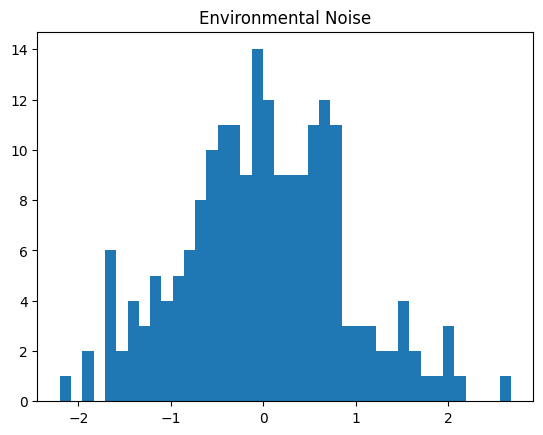

Mean of noise: -1.7763568394002505e-17
Standard deviation of noise: 0.8819217909554211


In [21]:

plt.hist(phenotype_df_post_normalization_h2["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_h2['environmental_noise'].std()))

We finally show how to simulate environmental noise after the genetic values have been normalized, with a narrow-sense heritability of 1 (default case) and user defined cases for the noise.

In [22]:
phenotype_post_normalization_default_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=0, std=1) #simulating noise after genetic values have been normalized with h2=1 and user defined with standard mean and std
phenotype_df_post_normalization_default_mean_and_std = phenotype_post_normalization_default_mean_and_std.phenotype_df
phenotype_df_post_normalization_default_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,1.616537,1.240969
1,0,1,0.686386,-1.260097,-0.573711
2,0,2,-0.436209,0.117658,-0.318550
3,0,3,1.373995,-0.053394,1.320601
4,0,4,0.213453,0.967468,1.180921
...,...,...,...,...,...
195,0,195,1.819668,0.292479,2.112147
196,0,196,2.123019,0.107526,2.230545
197,0,197,1.284972,-0.136626,1.148346
198,0,198,0.821750,0.593028,1.414778


In [23]:
phenotype_df_post_normalization_default_mean_and_std = normalize(phenotype_post_normalization_default_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_default_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_default_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].var()))
phenotype_df_post_normalization_default_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.4677210849294792
Variance of the noise is 0.5057426724447105


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.256852,1.038114,0.781263
1,0,1,0.469420,-0.929220,-0.459800
2,0,2,-0.298324,0.013029,-0.285295
3,0,3,0.939677,-0.103954,0.835723
4,0,4,0.145981,0.594215,0.740195
...,...,...,...,...,...
195,0,195,1.244474,0.132589,1.377062
196,0,196,1.451936,0.006099,1.458035
197,0,197,0.878794,-0.160876,0.717917
198,0,198,0.561996,0.338135,0.900130


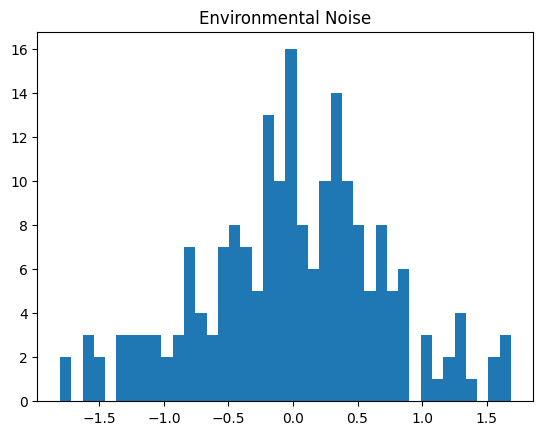

Mean of noise: -1.3322676295501878e-17
Standard deviation of noise: 0.7111558707095867


In [24]:

plt.hist(phenotype_df_post_normalization_default_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_default_mean_and_std['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_unique_mean_and_std = sim_env_noise(genetic_val_df_normalized, user_defined=True, mean=1, std=2) #simulating noise after genetic values have been normalized with h2=1 and user defined mean and std
phenotype_df_post_normalization_unique_mean_and_std = phenotype_post_normalization_unique_mean_and_std.phenotype_df
phenotype_df_post_normalization_unique_mean_and_std

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.375568,0.582848,0.207280
1,0,1,0.686386,-1.091971,-0.405585
2,0,2,-0.436209,-0.273529,-0.709737
3,0,3,1.373995,2.660934,4.034929
4,0,4,0.213453,-1.141973,-0.928520
...,...,...,...,...,...
195,0,195,1.819668,0.680562,2.500231
196,0,196,2.123019,1.710010,3.833030
197,0,197,1.284972,1.139286,2.424258
198,0,198,0.821750,-0.433381,0.388369


In [26]:
phenotype_df_post_normalization_unique_mean_and_std = normalize(phenotype_post_normalization_unique_mean_and_std)
print("Variance of the phenotypes is " + str(phenotype_df_post_normalization_unique_mean_and_std['phenotype'].var()))
print("Variance of the genetic values is " + str(phenotype_df_post_normalization_unique_mean_and_std['genetic_value'].var()))
print("Variance of the noise is " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].var()))
test5 = test_variance(phenotype_df_post_normalization_unique_mean_and_std)
phenotype_df_post_normalization_unique_mean_and_std

Variance of the phenotypes is 1.0000000000000002
Variance of the genetic values is 0.19006599600159943
Variance of the noise is 0.7538471097820866


,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.163735,-0.108418,-0.272152
1,0,1,0.299241,-0.838581,-0.539341
2,0,2,-0.190172,-0.481768,-0.671940
3,0,3,0.599015,0.797556,1.396571
4,0,4,0.093058,-0.860380,-0.767322
...,...,...,...,...,...
195,0,195,0.793313,-0.065818,0.727495
196,0,196,0.925563,0.382986,1.308550
197,0,197,0.560203,0.134170,0.694374
198,0,198,0.358255,-0.551459,-0.193204


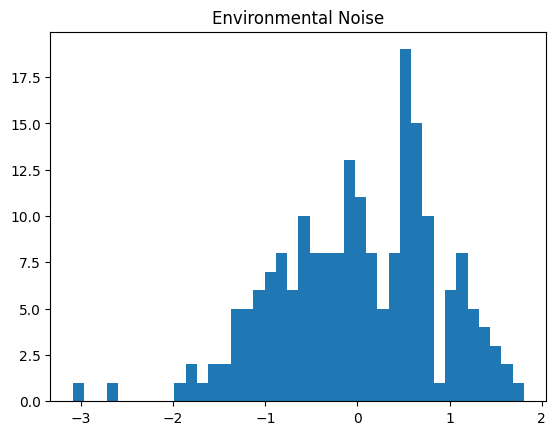

Mean of noise: -3.1086244689504386e-17
Standard deviation of noise: 0.868243692624419


In [27]:

plt.hist(phenotype_df_post_normalization_unique_mean_and_std["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotype_df_post_normalization_unique_mean_and_std['environmental_noise'].std()))

We show an example of converting the final phenotypes output to a standard .phen file format to be saved in the local directory.

In [28]:
local_path = 'post_noise_phenotypes.phen' #will be saved in a .phen file of this name in the local directory.
convert_to_phen(phenotype_df_post_normalization_unique_mean_and_std, local_path, include_header=True)